In [1]:
import numpy as np
import sys
import cv2
import scipy.fftpack as fft
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
quantization_matrix = np.matrix('16 11 10 16 24 40 51 61;'\
                                '12 12 14 19 26 58 60 55;'\
                                '14 13 16 24 40 57 69 56;'\
                                '14 17 22 29 51 87 80 62;'\
                                '18 22 37 56 68 109 103 77;'\
                                '24 35 55 64 81 104 113 92;'\
                                '49 64 78 87 103 121 120 101;'\
                                '72 92 95 98 112 100 103 99')

# An array of indices that we use to sample a flattened DCT array in zigzag order.
zz_indices = [ 0,  1,  8, 16,  9,  2,  3, 10,
               17, 24, 32, 25, 18, 11, 4,  5,
               12, 19, 26, 33, 40, 48, 41, 34,
               27, 20, 13,  6,  7, 14, 21, 28,
               35, 42, 49, 56, 57, 50, 43, 36,
               29, 22, 15, 23, 30, 37, 44, 51,
               58, 59, 52, 45, 38, 31, 39, 46,
               53, 60, 61, 54, 47, 55, 62, 63]

# An reversed array of zz_indices that we use to regenerate matrix
reversed_zz_indices = [0, 1, 5, 6, 14,15,27,28,
                       2, 4, 7, 13,16,26,29,42,
                       3, 8, 12,17,25,30,41,43,
                       9, 11,18,24,31,40,44,53,
                       10,19,23,32,39,45,52,54,
                       20,22,33,38,46,51,55,60,
                       21,34,37,47,50,56,59,61,
                       35,36,48,49,57,58,62,63]

In [3]:
class Frame:

    def __init__(self, image):
        '''
        @param image: RBG image of shape (height, width, 3)
        @param QF: quality factor, normally range from 0.1 to 1.5
        '''
        self.image = image
        self.r = image[:, :, 0]
        self.g = image[:, :, 1]
        self.b = image[:, :, 2]
        self.v_mblocks = np.shape(self.r)[0] // 16
        self.h_mblocks = np.shape(self.r)[1] // 16

    def getFrame(self):
        reconstructed_image = np.dstack((self.r, self.g, self.b))
        return reconstructed_image
        
    def show(self):
        self.getFrame()
        plt.imshow(self.getFrame())
    
    def getBlock(self,m,n):
        m_start = m*16
        n_start = n*16
        tmp = self.image[m_start:m_start+16,n_start:n_start+16]
        #plt.imshow(tmp)
        return tmp
    
    def encode_block(self,src,QF):
        """
        @param src: A 16*16*3 block
        @return encoded_string: A list of 6 lists of encoded pairs for each block in [Y1,Y2,Y3,Y3,subsampled_Cb,subsampled_Cr]. 
                                in the form [<DC term> <run, level> <EOB>] 
        """
        def subsample(src):
            """
            @param src: A 16*16 block
            @return rst: 8*8 subsampled blcok, with mean of each 2x2 block
            """
            rst = []
            for i in range(0,len(src),2):
                for j in range(0,len(src),2):
                    rst.append(np.mean([src[i][j],src[i][j+1],src[i+1][j],src[i+1][j+1]]))
            rst = np.array(rst)
            rst = rst.reshape(8,8).astype(np.uint8)
            return rst

        def quantize(F,QF):
            quant_matrix=np.ceil(quantization_matrix*QF)
            #print(quant_matrix)
            quant_matrix[quant_matrix>255]=255
            #print(F,quant_matrix)
            return (F/quant_matrix).astype(np.int)

        def dct_quantize_zz(F):
            dct2_F = dct(F)
            qtz_F = quantize(dct2_F,QF)
            zz_series = [qtz_F.A1[i] for i in zz_indices]
            encoded = zigzag_from_flattened_block(zz_series)
            return encoded


        def run_level(tmp):
            """
            process the middle part -- <run, level>
            @param tmp: A list of numbers
            @return encoded_string: A list of <run, level> pair
            """
            def prefix_0(s):
                """
                @param s: A series of integers
                @return count: Number of prefix 0s
                """
                if len(s)==0:
                    return 0
                i, count = 0, 0
                while s[i]==0 :
                    count += 1
                    if i==len(s)-1:
                        return count
                    i+=1
                return count

            encoded_string = []
            while True:
                a = prefix_0(tmp)
                if a==len(tmp):
                    break
                encoded_string.append([a,tmp[a]])
                tmp = tmp[a+1:]
            return encoded_string


        def zigzag_from_flattened_block(tmp):
            """
            @param tmp: A zigzag series of coeffs
            @return encoded_string: A list, in the form <DC term> <run, level> <EOB>
            """
            encoded_string = [tmp[0]]
            encoded_string += run_level(tmp[1:])
            encoded_string.append('EOB')
            return encoded_string    

        def dct(y):
            return fft.dct(fft.dct(y, axis=0, norm='ortho', type=2), axis=1, norm='ortho', type=2)

        YCrCb = cv2.cvtColor(src, cv2.COLOR_RGB2YCR_CB)
        Y,Cb,Cr = cv2.split(YCrCb)

        Y1 = Y[:8,:8]
        Y2 = Y[:8,8:]
        Y3 = Y[8:,:8]
        Y4 = Y[8:,8:]
        subsample_Cb = subsample(Cb)
        subsample_Cr = subsample(Cr)
        return [dct_quantize_zz(Y1),dct_quantize_zz(Y2),dct_quantize_zz(Y3),dct_quantize_zz(Y4),
                dct_quantize_zz(subsample_Cb),dct_quantize_zz(subsample_Cr)]
    
    
    def decode_block(self,F,QF):
        def zigzag_to_flattened_block(encoded_string):
            """
            @param encoded_string: A list in the form <DC term> <run, level> <EOB>
            @return rst: A zigzag series of coeffs
            """
            rst = [encoded_string[0]]
            for i in encoded_string[1:-1]:
                #print(i)
                for _ in range(i[0]):
                    rst.append(0)
                rst.append(i[1])
            #print(16-len(rst))
            for i in range(64-len(rst)):
                rst.append(0)
            return rst

        def de_quantize(F,QF):
            quant_matrix=np.ceil(quantization_matrix*QF)
            quant_matrix[quant_matrix>255]=255
            tmp = []
            for i in range(8):
                for j in range(8):
                    #tmp1 = F[i][j]*quant_matrix.A[i][j]
                    #print(tmp1)
                    tmp.append(int(F[i][j]*quant_matrix.A[i][j]))
            return np.array(tmp).reshape(8,8)

        def idct(y):
            return fft.idct(fft.idct(y, axis=0, norm='ortho', type=2), axis=1, norm='ortho', type=2)

        def regenerate(src8_8):
            """
            @param src8_8: A 8*8 downsampled block 
            @return regenerated_16_16: A 16*16 block, expanding each pixel to 2*2.
            """
            #print(src8_8)
            rst16_16_flattened=[]
            for i in range(8):
                for j in range(8):
                    #print(src8_8[i][j])
                    rst16_16_flattened.append(src8_8[i][j])
                    rst16_16_flattened.append(src8_8[i][j])
                for j in range(8):
                    #print(src8_8[i][j])
                    rst16_16_flattened.append(src8_8[i][j])
                    rst16_16_flattened.append(src8_8[i][j])
            regenerated_16_16 = np.array(rst16_16_flattened).reshape(16,16)
            return regenerated_16_16

        rst = []
        for i in F:
            decoded_F = zigzag_to_flattened_block(i)
            de_flattened_F = np.array([decoded_F[i] for i in reversed_zz_indices]).reshape(8,8)
            de_quantized_F = de_quantize(de_flattened_F,QF)
            regenerated_F = idct(de_quantized_F).astype(int)
            rst.append(regenerated_F)
        Y1,Y2,Y3,Y4,subsample_Cb,subsample_Cr = rst
        rst=[]
        for i in range(8):
            tmp = list(Y1[i])+list(Y2[i])
            rst+=tmp
        #print(rst)
        for i in range(8):
            tmp = list(Y3[i])+list(Y4[i])
            rst+=tmp
        regenerated_Y = np.array(rst).reshape(16,16)
        regenerate_Cb = regenerate(subsample_Cb)
        regenerate_Cr = regenerate(subsample_Cr)
        regenerated_block = cv2.merge((regenerated_Y, regenerate_Cb, regenerate_Cr)).astype(np.uint8)
        regenerated_block = cv2.cvtColor(regenerated_block,cv2.COLOR_YCR_CB2RGB)
        return regenerated_block

In [58]:
def compare_block(m,n,QF):
    tmp = pic.getBlock(m,n)
    #print(tmp.shape)
    tmp1 = pic.encode_block(tmp,QF)
    tmp2 = pic.decode_block(tmp1,QF)
    
    plt.figure(figsize=(6,2))
    plt.subplot(121)
    plt.title('Regenerated block QF={}'.format(QF))
    plt.imshow(tmp2)
    plt.subplot(122)
    plt.title('Original block')
    plt.imshow(tmp)
    plt.show()

(480, 640, 3)


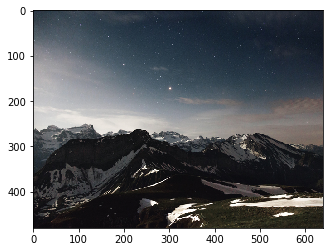

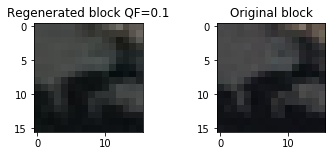

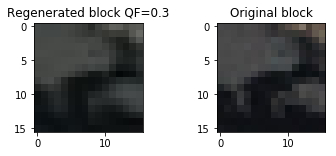

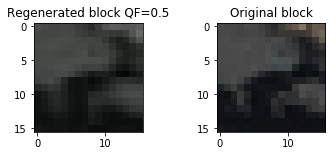

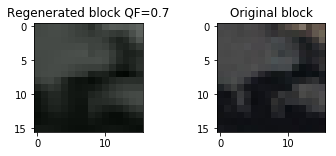

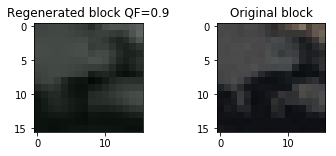

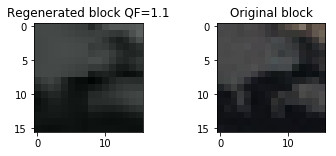

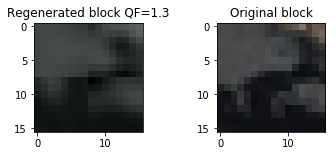

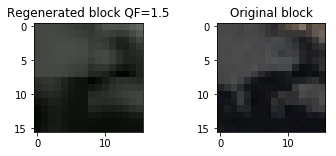

In [72]:
# Compare encoded and then decoded block with the original block, using different QF ranging from 0.1-1.5
img_name = 'night.jpg'
fullPic = plt.imread(img_name)
print(fullPic.shape)
#fullPic = plt.imread(img_name)[:224,:224]
pic = Frame(fullPic)
plt.imshow(fullPic)
for i in np.arange(1,16,2)/10:
    #print(i)
    compare_block(20,30,i)

In [68]:
def compare_pics(pic, QF):
    blocks = []
    for m in range(pic.v_mblocks):
        for n in range(pic.h_mblocks):
            block = pic.getBlock(m,n)
            encoded_block = pic.encode_block(block,QF)
            decoded_block = pic.decode_block(encoded_block,QF)
            blocks.append(decoded_block)
    f=[]
    for m in range(pic.v_mblocks):
        rst = []
        for i in range(16):
            for n in range(pic.h_mblocks):
                block = blocks[m*pic.h_mblocks+n]
                rst+=list(block[i])
        #print(len(rst))
        f+=rst
    #print(len(f))
    f = np.array(f).reshape(pic.v_mblocks*16,pic.h_mblocks*16,3)
    
    plt.figure(figsize=(15,8))
    plt.subplot(121)
    plt.title('Regenerated picture QF={}'.format(QF))
    plt.imshow(f)
    plt.subplot(122)
    plt.title('Original picture')
    plt.imshow(pic.getFrame())
    plt.show()

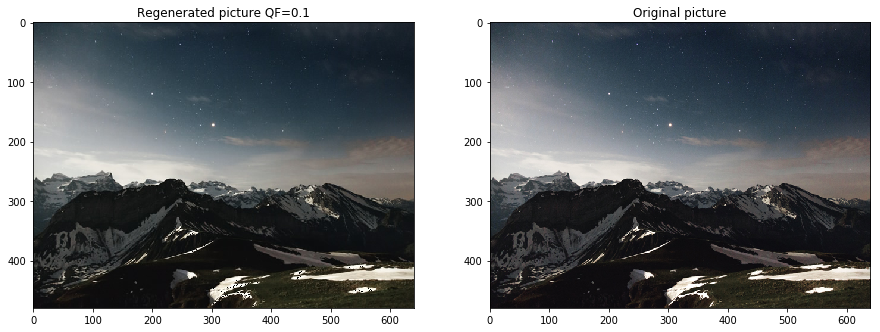

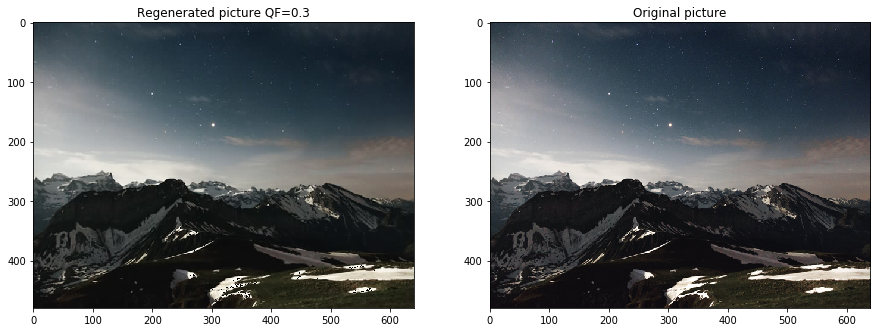

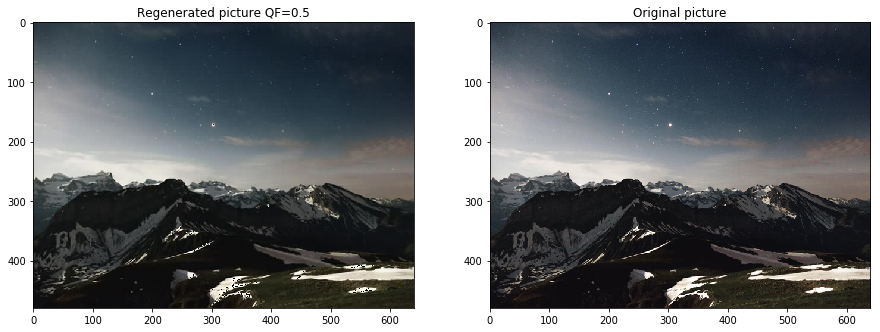

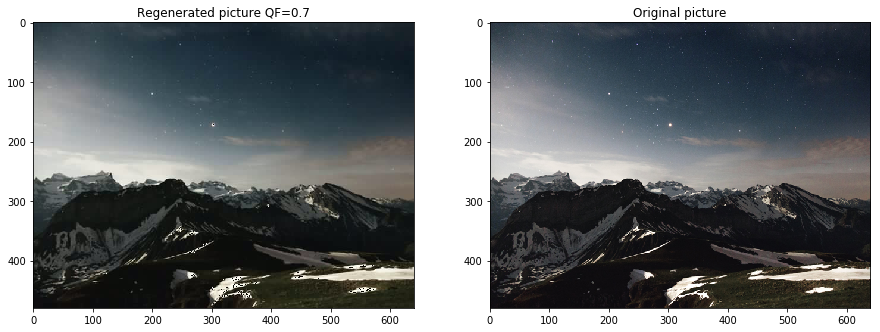

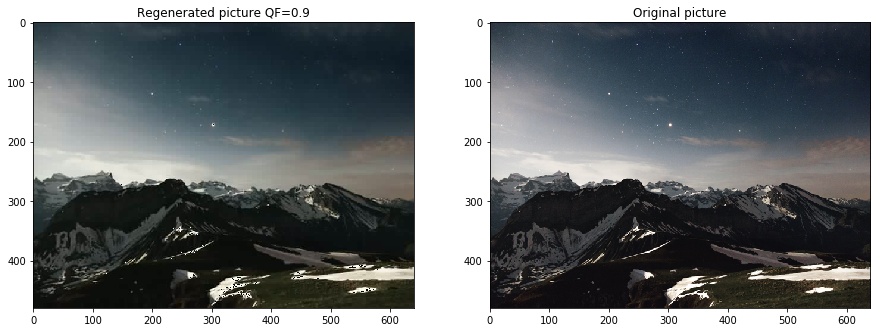

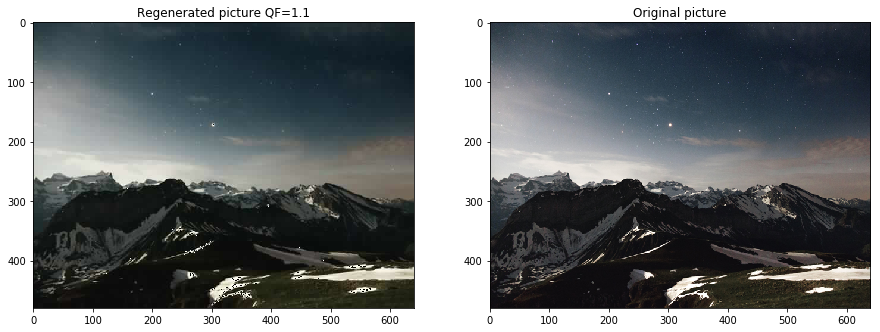

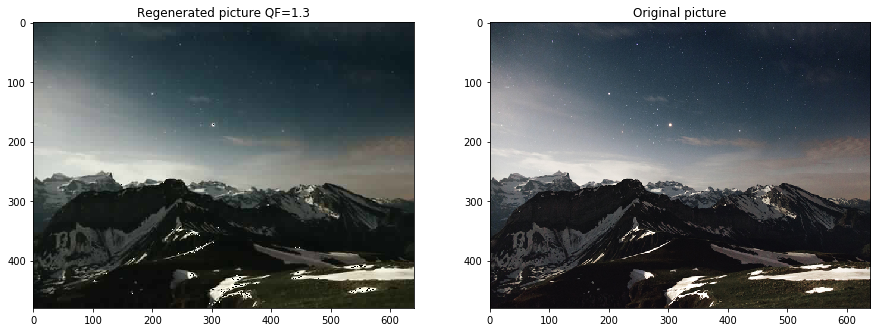

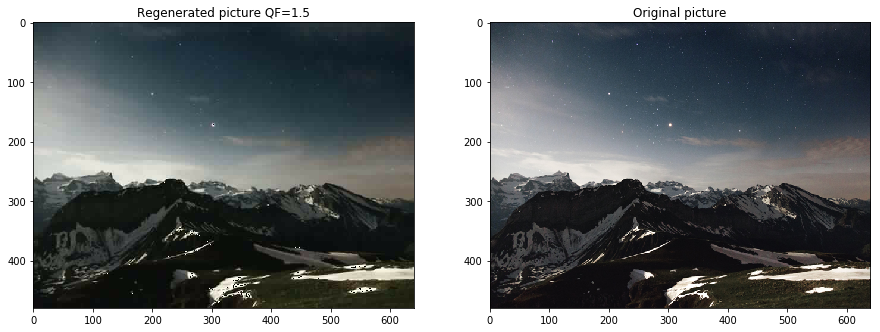

In [73]:
# Compare encoded and then decoded full picture with the original picture, using different QF ranging from 0.1-1.5
for QF in np.arange(1,16,2)/10:
    compare_pics(pic,QF)